In [1]:
import sys
sys.path.append("../..")

import os
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import time

import pysingfel as ps
#import pysingfel.gpu as pg
#from pysingfel.ff_waaskirf_database import *

In [2]:
def get_particle_as_list(atoms):
    atom_types = {'H': 1, 'HE': 2, 'C': 6, 'N1+': 6, 'N': 7, 'O': 8, 'O1-': 9, 'P': 15, 'S': 16, 'CL': 18, 'FE': 26}
    all_atoms = []
    for atom_info in atoms:
        for info in atom_info:
            if type(info) == str:
                atom = info
            elif len(info) == 3:
                coordinates = info
            else:
                raise ValueError('Invalid atom information!')
        atomic_number = atom_types[atom]
        total_atom = [coordinates[0], coordinates[1], coordinates[2], atomic_number, 0]
        all_atoms.append(total_atom)                                      # charge = 0 (by default)
    atoms = np.asarray(all_atoms)
                                                                                    
    particle = ps.Particle()
    particle.atom_pos = atoms[:, 0:3] * 1e-10
    tmp = (100 * atoms[:, 3] + atoms[:, 4]).astype(int)
    atom_type, idx = np.unique(np.sort(tmp), return_index=True)
    particle.num_atom_types = len(atom_type)
    particle.split_idx = np.append(idx, [len(tmp)])
    qs = np.linspace(0, 10, 101) / (2.0 * np.pi * 0.529177206 * 2.0)
    particle.q_sample = qs
    particle.compton_q_sample = qs
    particle.num_q_samples = len(qs)
    particle.sBound = np.zeros(particle.num_q_samples)
    particle.nFree = np.zeros(particle.num_q_samples)
    
    wk_dbase = load_waaskirf_database()
    for i in idx:
        if i == 0:
            zz = atoms[i, 3]
            qq = atoms[i, 4]
            idx1 = np.where(wk_dbase[:, 0] == zz)[0]
            flag = True
            for j in idx1:
                if int(wk_dbase[j, 1]) == qq:
                    [a1, a2, a3, a4, a5, c, b1, b2, b3, b4, b5] = wk_dbase[j, 2:]
                    particle.ff_table = (a1 * np.exp(-b1 * particle.q_sample ** 2) +
                                         a2 * np.exp(-b2 * particle.q_sample ** 2) +
                                         a3 * np.exp(-b3 * particle.q_sample ** 2) +
                                         a4 * np.exp(-b4 * particle.q_sample ** 2) +
                                         a5 * np.exp(-b5 * particle.q_sample ** 2) + c)
                    flag = False
                    break
                    if flag:
                        print('Atom number = ' + str(zz) + ' with charge ' + str(qq))
                        raise ValueError('Unrecognized atom type!')
        else:
            zz = int(atoms[i, 3])  # atom type
            qq = int(atoms[i, 4])  # charge
            idx1 = np.where(wk_dbase[:, 0] == zz)[0]
            flag = True
            for j in idx1:
                if int(wk_dbase[j, 1]) == qq:
                    # print "Enter: ", j
                    [a1, a2, a3, a4, a5, c, b1, b2, b3, b4, b5] = wk_dbase[j, 2:]

                    ff = (a1 * np.exp(-b1 * particle.q_sample ** 2) +
                          a2 * np.exp(-b2 * particle.q_sample ** 2) +
                          a3 * np.exp(-b3 * particle.q_sample ** 2) +
                          a4 * np.exp(-b4 * particle.q_sample ** 2) +
                          a5 * np.exp(-b5 * particle.q_sample ** 2) + c)
                    particle.ff_table = np.vstack((particle.ff_table, ff))
                    flag = False
                    break
                if flag:
                    print('Atom number = ' + str(zz) + ' with charge ' + str(qq))
                    raise ValueError('Unrecognized atom type!')

    
    return particle

In [3]:
# Load beam
beam = ps.Beam('../input/exp_chuck.beam') 

# Load and initialize the detector
det = ps.PnccdDetector(geom = '../lcls/amo86615/PNCCD::CalibV1/Camp.0:pnCCD.1/geometry/0-end_Bharat.data', 
                       beam = beam)

# Rotate the particle to make the "circle" perpendicular to the detector.
theta = np.pi/2
#particle.rotate(np.array([np.cos(theta/2), 0, np.sin(theta/2), 0]))


In [4]:
no_pixels = np.linspace(0, 512, 50)
pixel_size = 75e-6            # in m per pixel
detector_distance = 0.15      #in m
theta_max = np.arctan(no_pixels*pixel_size/detector_distance)
d_min = beam.wavelength/(2*np.sin(theta_max))
#print((np.sin(theta_max)/beam.wavelength)* 1e-10)

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.3.10/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in divide


In [6]:
1/d_min

array([  0.00000000e+00,   3.87667551e+07,   7.75303360e+07,
         1.16287570e+08,   1.55035286e+08,   1.93770319e+08,
         2.32489507e+08,   2.71189696e+08,   3.09867738e+08,
         3.48520495e+08,   3.87144840e+08,   4.25737657e+08,
         4.64295842e+08,   5.02816307e+08,   5.41295976e+08,
         5.79731793e+08,   6.18120717e+08,   6.56459728e+08,
         6.94745824e+08,   7.32976025e+08,   7.71147373e+08,
         8.09256933e+08,   8.47301796e+08,   8.85279077e+08,
         9.23185917e+08,   9.61019486e+08,   9.98776980e+08,
         1.03645563e+09,   1.07405269e+09,   1.11156545e+09,
         1.14899123e+09,   1.18632738e+09,   1.22357130e+09,
         1.26072040e+09,   1.29777214e+09,   1.33472401e+09,
         1.37157356e+09,   1.40831834e+09,   1.44495595e+09,
         1.48148406e+09,   1.51790033e+09,   1.55420249e+09,
         1.59038832e+09,   1.62645560e+09,   1.66240220e+09,
         1.69822600e+09,   1.73392492e+09,   1.76949694e+09,
         1.80494009e+09,

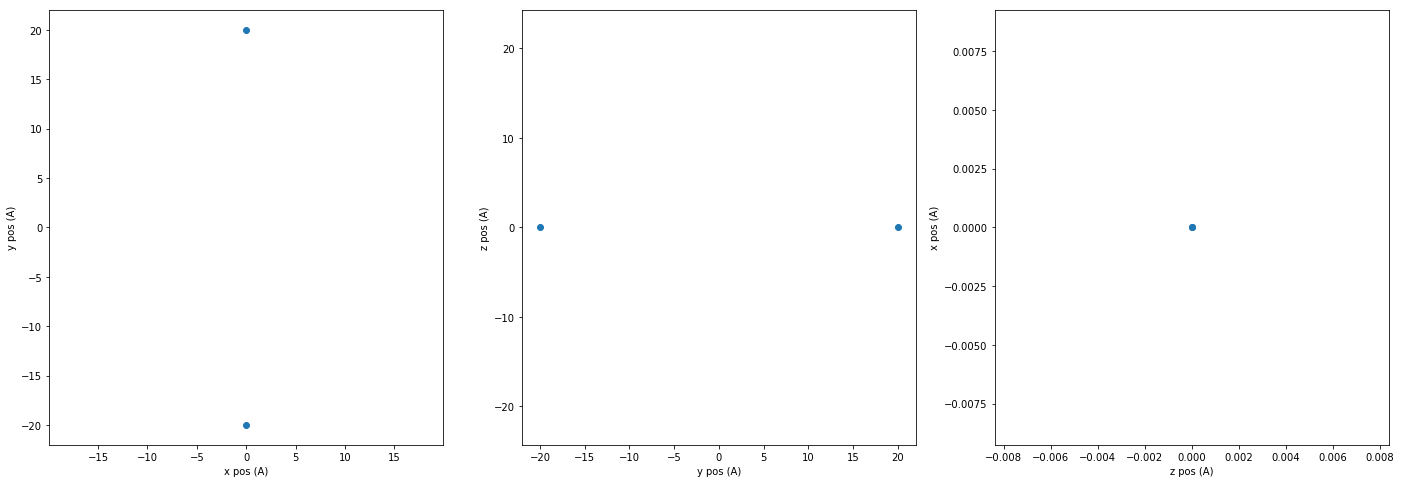

In [26]:
plt.figure(figsize=(24, 8))
plt.subplot(1, 3, 1)
plt.scatter(particle.atom_pos[:, 0]*1e10, particle.atom_pos[:, 1]*1e10)
plt.xlabel('x pos (A)')
plt.ylabel('y pos (A)')
plt.xlim(-120, 120)
plt.ylim(-120, 120)
plt.axis('equal')

plt.subplot(1, 3, 2)
plt.scatter(particle.atom_pos[:, 1]*1e10, particle.atom_pos[:, 2]*1e10)
plt.xlabel('y pos (A)')
plt.ylabel('z pos (A)')
plt.xlim(-120, 120)
plt.ylim(-120, 120)
plt.axis('equal')

plt.subplot(1, 3, 3)
plt.scatter(particle.atom_pos[:, 2]*1e10, particle.atom_pos[:, 0]*1e10)
plt.xlabel('z pos (A)')
plt.ylabel('x pos (A)')
plt.xlim(-120, 120)
plt.ylim(-120, 120)
plt.axis('equal')
plt.show()

# Calculate the 3D diffraction volume

In [5]:
mesh_length = 101

# Setup the reciprocal space mesh grid for the detector
# The edge pixel resolution is slightly larger than the corner resolution of the detector panel.
mesh, voxel_length = det.get_reciprocal_mesh(voxel_number_1d=mesh_length)

# Compute Slice from Volume

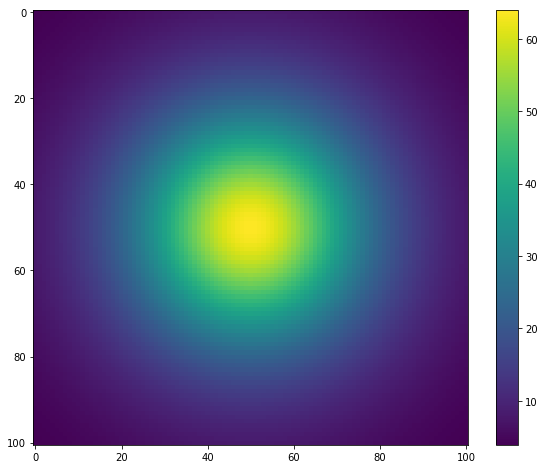

In [6]:
# Plot of the pattern (for 1 atom)
d = 5e4
atoms = [("O", (0, 0, 0))]
particle = get_particle_as_list(atoms)

volume_ref = pg.calculate_diffraction_pattern_gpu(mesh, particle)
plt.figure(figsize=(10, 8))
plt.imshow(volume_ref[:, :, mesh_length/2])
plt.colorbar()
plt.show()

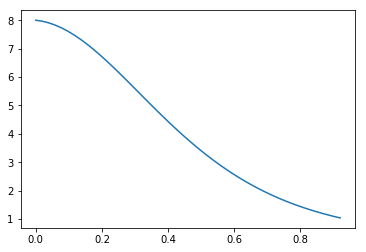

In [9]:
intensities = volume_ref[51:101, 51, mesh_length/2]
norm_int = 8 * intensities / max(intensities)
plt.plot(np.sin(theta_max)/beam.wavelength * 1e-9, norm_int)
plt.show()

In [24]:
x_vals = np.sin(theta_max)/beam.wavelength * 1e-9
idx = np.where(x_vals < 0.6)
print(norm_int)
print(x_vals)

[ 8.          7.96586167  7.90948954  7.83151941  7.73285032  7.61463499
  7.47822069  7.32509967  7.15691559  6.97539395  6.78233592  6.579558
  6.36888054  6.15208297  5.93088763  5.70692854  5.48174234  5.25674132
  5.03321987  4.81232751  4.59508915  4.3823826   4.17496197  3.97344807
  3.77834401  3.59004259  3.40882994  3.23490698  3.06838375  2.90930708
  2.75765259  2.61334932  2.47627606  2.34627723  2.22316582  2.10673021
  1.99674212  1.89295705  1.79512407  1.70298367  1.61627612  1.53473978
  1.45811639  1.38615093  1.31859393  1.25520269  1.19574146  1.1399833
  1.08770933  1.03871027]
[ 0.          0.01938338  0.03876517  0.05814378  0.07751764  0.09688516
  0.11624475  0.13559485  0.15493387  0.17426025  0.19357242  0.21286883
  0.23214792  0.25140815  0.27064799  0.2898659   0.30906036  0.32822986
  0.34737291  0.36648801  0.38557369  0.40462847  0.4236509   0.44263954
  0.46159296  0.48050974  0.49938849  0.51822781  0.53702634  0.55578272
  0.57449561  0.59316369  0.

In [8]:
volume_ref[51:101, :, :].shape

(50, 101, 101)

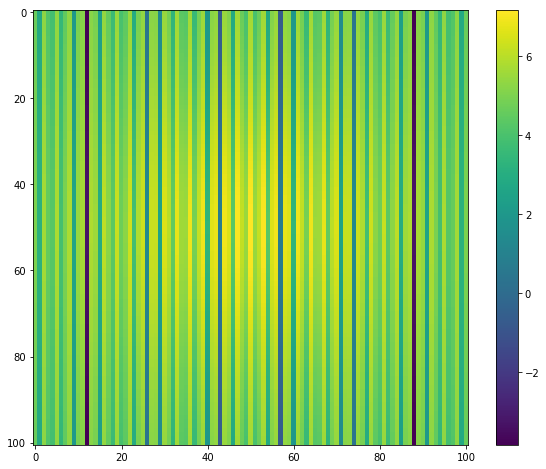

In [12]:
# Plot of the pattern (2 atoms symmetrically on the x-axis)
d = 5e2
atoms = [("CL", (d, 0, 0)), ("CL", (-d, 0, 0))]
particle = get_particle_as_list(atoms)

volume_ref = pg.calculate_diffraction_pattern_gpu(mesh, particle)
plt.figure(figsize=(10, 8))
plt.imshow(np.log(volume_ref[:, :, mesh_length/2]))
plt.colorbar()
plt.show()

[[  0  20   0  16   0]
 [  0 -20   0  16   0]]
(2, 5)


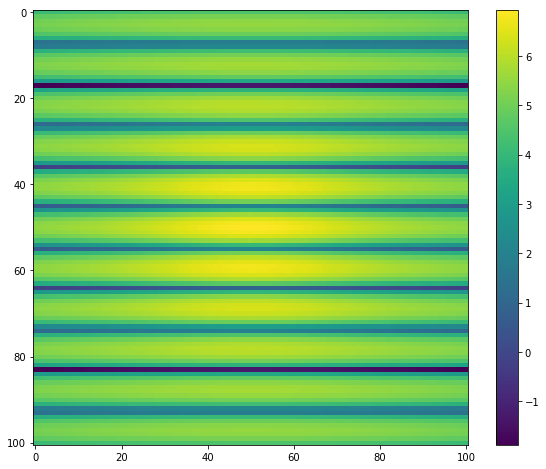

In [25]:
# Plot of the pattern (2 atoms symmetrically on the y-axis)
d = 20
atoms = [("S", (0, d, 0)), ("S", (0, -d, 0))]
particle = get_particle_object(atoms)

volume_ref = pg.calculate_diffraction_pattern_gpu(mesh, particle)
plt.figure(figsize=(10, 8))
plt.imshow(np.log(volume_ref[:, :, mesh_length/2]))
plt.colorbar()
plt.show()

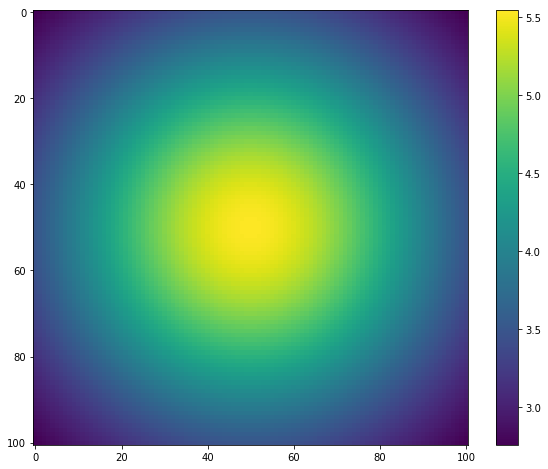

In [20]:
# Plot of the pattern (2 atoms symmetrically on the z-axis)
d = 5e4
atoms = [("O", (0, 0, d)), ("O", (0, 0, -d))]
particle = get_particle_as_list(atoms)

volume_ref = pg.calculate_diffraction_pattern_gpu(mesh, particle)
plt.figure(figsize=(10, 8))
plt.imshow(np.log(volume_ref[:, :, mesh_length/2]))
plt.colorbar()
plt.show()

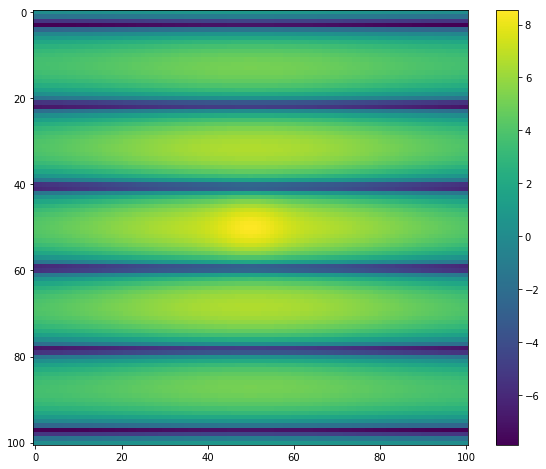

In [14]:
# Plot of the pattern (4 atoms symmetrically on y & z axes)
d = 5
atoms = [("CL", (0, d, 0)), ("CL", (0, -d, 0)), ("CL", (0, 0, d)), ("CL", (0, 0, -d))]
particle = get_particle_object(atoms)

volume_ref = pg.calculate_diffraction_pattern_gpu(mesh, particle)
plt.figure(figsize=(10, 8))
plt.imshow(np.log(volume_ref[:, :, mesh_length/2]))
plt.colorbar()
plt.show()

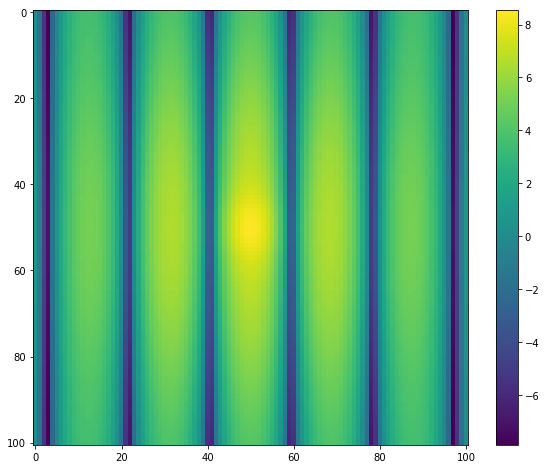

In [15]:
# Plot of the pattern (4 atoms symmetrically on x & z axes)
d = 5
atoms = [("CL", (d, 0, 0)), ("CL", (-d, 0, 0)), ("CL", (0, 0, d)), ("CL", (0, 0, -d))]
particle = get_particle_object(atoms)

volume_ref = pg.calculate_diffraction_pattern_gpu(mesh, particle)
plt.figure(figsize=(10, 8))
plt.imshow(np.log(volume_ref[:, :, mesh_length/2]))
plt.colorbar()
plt.show()

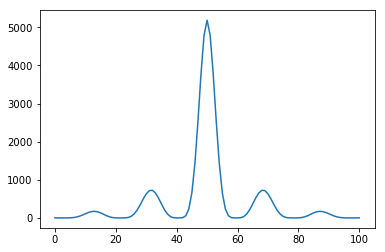

In [22]:
plt.plot(volume_ref[:, 50, mesh_length/2])
plt.show()

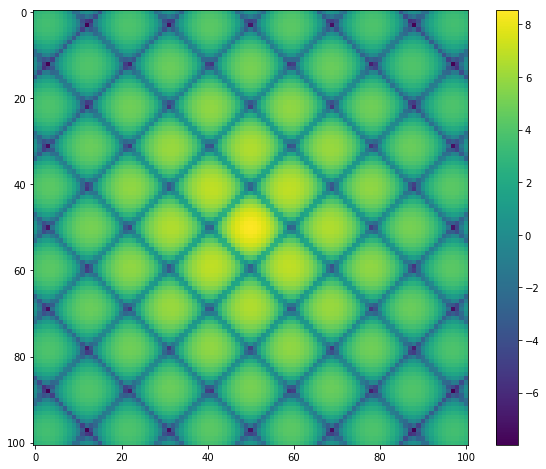

In [16]:
# Plot of the pattern (4 atoms symmetrically on the x & y axes)
d = 5
atoms = [("CL", (d, 0, 0)), ("CL", (-d, 0, 0)), ("CL", (0, d, 0)), ("CL", (0, -d, 0))]
particle = get_particle_object(atoms)

volume_ref = pg.calculate_diffraction_pattern_gpu(mesh, particle)
plt.figure(figsize=(10, 8))
plt.imshow(np.log(volume_ref[:, :, mesh_length/2]))
plt.colorbar()
plt.show()

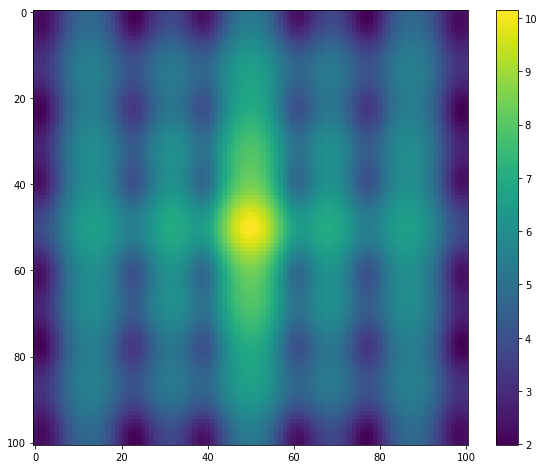

In [10]:
# Plot of the pattern (in xyz space)
d = 2.5
atoms = [("S", (2*d, 0, 0)), ("S", (d, 0, 0, 16)), ("S", (-d, 0, 0)), ("S", (-2*d, 0, 0)),
        ("C", (0, 2*d, 0)), ("C", (0, d, 0)), ("C", (0, -d, 0)), ("C", (0, -2*d, 0)),
        ("CL", (0, 0, 2*d)), ("CL", (0, 0, d)), ("CL", (0, 0, -d)), ("CL", (0, 0, -2*d))]
particle = get_particle_object(atoms)

volume_ref = pg.calculate_diffraction_pattern_gpu(mesh, particle)
plt.figure(figsize=(10, 8))
plt.imshow(np.log(volume_ref[:, :, mesh_length/2]))
plt.colorbar()
plt.show()

In [6]:
theta = np.pi/2
orientations = np.array([
    [1., 0., 0., 0.],
    [np.cos(theta/2), np.sin(theta/2), 0, 0],
    [np.cos(theta/2), 0, np.sin(theta/2), 0],
    [np.cos(theta/2), 0, 0, np.sin(theta/2)]])

In [1]:
particle.rotate(orientations[2])
volume_rot = pg.calculate_diffraction_pattern_gpu(mesh, particle)
plt.imshow(np.log(volume_rot[:, :, mesh_length/2]))
plt.show()

NameError: name 'particle' is not defined

In [8]:
slices_1 = ps.geometry.take_n_slice(
    pattern_shape = det.pedestal.shape,
    pixel_momentum = det.pixel_position_reciprocal,
    volume = volume_ref,
    voxel_length = voxel_length,
    orientations = orientations,
    inverse = True)

Deprecation warning: The typo was corrected. Please use 'take_n_slices' instead. Note, however, than the signatures have changed!
Finishing constructing 4 patterns in 3.474132 seconds


In [9]:
slices_2 = ps.geometry.take_n_slice(
    pattern_shape = det.pedestal.shape,
    pixel_momentum = det.pixel_position_reciprocal,
    volume = volume_rot,
    voxel_length = voxel_length,
    orientations = orientations,
    inverse = True)

Deprecation warning: The typo was corrected. Please use 'take_n_slices' instead. Note, however, than the signatures have changed!
Finishing constructing 4 patterns in 3.435623 seconds


/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.4.2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


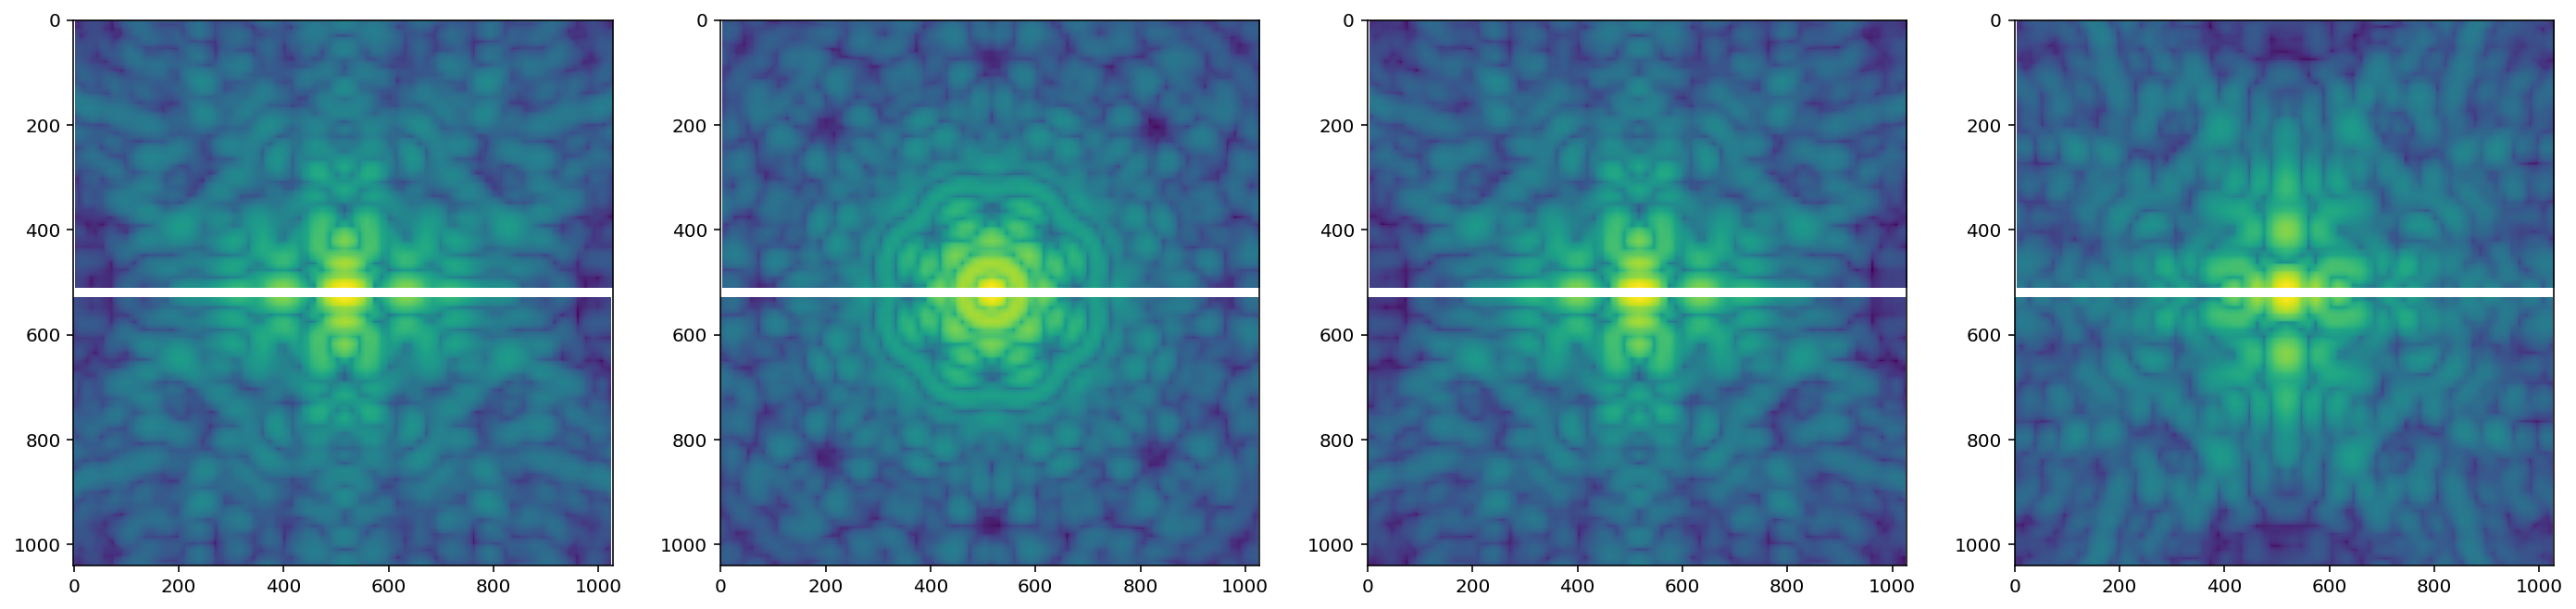

In [10]:
images = det.assemble_image_stack_batch(image_stack_batch=slices_1)
plt.figure(figsize=(24, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(np.log(images[i]))
plt.show()

/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.4.2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


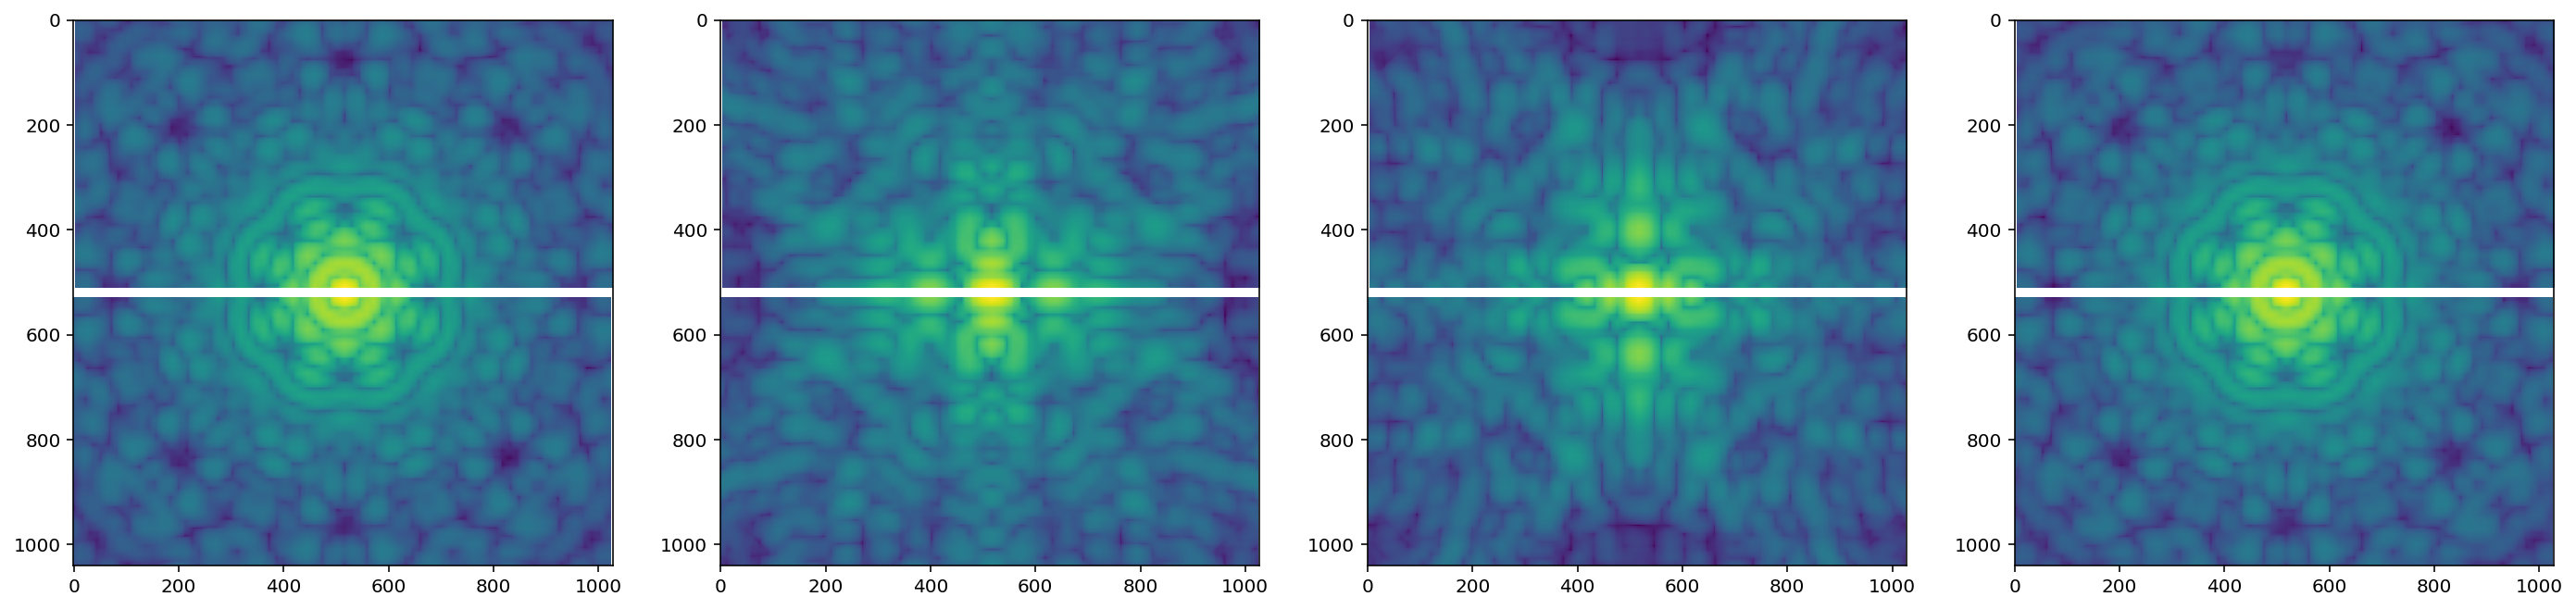

In [11]:
images = det.assemble_image_stack_batch(image_stack_batch=slices_2)
plt.figure(figsize=(24, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(np.log(images[i]))
plt.show()